# 第5回演習課題

MNISTデータの読み込み

In [1]:
import theano.sandbox.cuda
theano.sandbox.cuda.use("gpu1") #gpu1, gpu2, gpu3

Using gpu device 1: GeForce GTX TITAN X


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

In [3]:
from sklearn.metrics import f1_score
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [4]:
mnist = fetch_mldata('MNIST original')
mnist_x, mnist_y = mnist.data.astype("float32")/255.0, mnist.target.astype("int32")

train_X, test_X, train_y, test_y = train_test_split(mnist_x, mnist_y, test_size=0.2)

## 課題1：Denoising auto-encoderの実装．また，MNISTを用いて次のことを確認．
* reconstruction errorが小さくなっている（学習が進んでいる）．
* 重みの可視化（特徴の可視化）．

In [5]:
import numpy as np
import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams
from collections import OrderedDict

In [6]:
rng = np.random.RandomState(1234)
theano_rng = RandomStreams(rng.randint(1234))

In [7]:
def sgd(params,gparams,lr=0.1):
    updates = OrderedDict()
    for param, gparam in zip(params, gparams):
        updates[param] = param - lr * gparam
    return updates

Autoencoderクラス

In [8]:
class Autoencoder:
    def __init__(self, visible_dim, hidden_dim, function):
        self.visible_dim = visible_dim
        self.hidden_dim = hidden_dim
        self.function = function
        
        self.W = theano.shared(rng.uniform(
                    low=-4*np.sqrt(6. / (visible_dim + hidden_dim)),
                    high=4*np.sqrt(6. / (visible_dim + hidden_dim)),
                    size=(visible_dim,hidden_dim)
                ).astype("float32"), name="W")
        
        self.a = theano.shared(np.zeros(visible_dim).astype(np.float32), name="a")
        self.b = theano.shared(np.zeros(hidden_dim).astype(np.float32), name="b")

        self.params = [self.W, self.a, self.b]
        
    #encoder #5.1
    def encode(self, x):
        u = T.dot(x, self.W) + self.b
        y = self.function(u)
        return y
    
    #decoder #5.1
    def decode(self, x):
        u = T.dot(x, self.W.T) + self.a # weight sharing
        y = self.function(u)
        return y
    
    #forward propagation #5.1
    def prop(self, x):
        y = self.encode(x)
        reconst_x = self.decode(y)
        return reconst_x
    
    #reconstruction error
    def reconst_error(self, x, noise):
        tilde_x = x*noise
        reconst_x = self.prop(tilde_x)
        error = T.mean(T.sum(T.nnet.binary_crossentropy(reconst_x, x), axis=1))
        return error, reconst_x

In [9]:
model = Autoencoder(train_X.shape[1], 500, T.nnet.sigmoid)

x = T.matrix('x')
noise = T.matrix('noise')

cost, reconst_x = model.reconst_error(x, noise)
params  = model.params
gparams = T.grad(cost, params)
updates = sgd(params, gparams) 

train = theano.function([x, noise], [cost, reconst_x], updates=updates, allow_input_downcast=True)

In [10]:
corruption_level = 0.3
batch_size = 100
nbatches = train_X.shape[0] // batch_size

for epoch in range(10):
    train_X = shuffle(train_X)
    err_all=[]
    for i in range(0,nbatches):
        start = i * batch_size
        end   = start + batch_size
        
        noise = rng.binomial(size=train_X[start:end].shape, n=1, p=1-corruption_level)
        err, reconst_x = train(train_X[start:end],noise)
        err_all.append(err)
    print("Epoch:%d, Error:%lf" %(epoch+1, np.mean(err)))

Epoch:1, Error:82.873962
Epoch:2, Error:75.060577
Epoch:3, Error:79.762527
Epoch:4, Error:73.903275
Epoch:5, Error:72.582230
Epoch:6, Error:71.274002
Epoch:7, Error:76.106964
Epoch:8, Error:71.950203
Epoch:9, Error:72.297043
Epoch:10, Error:69.476784


重みの可視化
* corruption_levelを変更して違いを観測

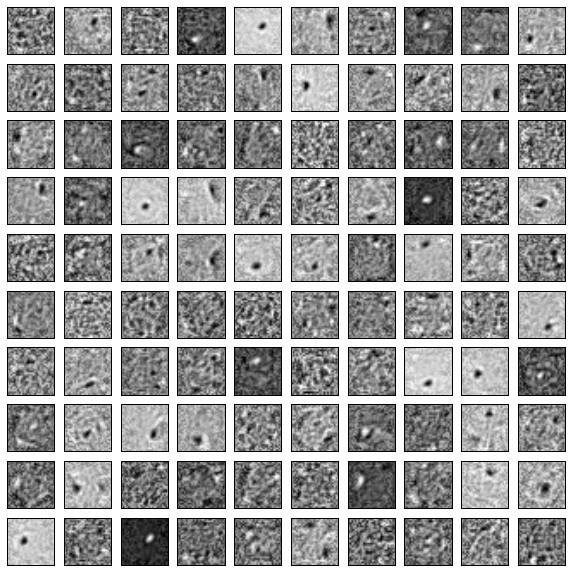

In [11]:
weight = model.W.get_value(borrow=True).T

fig = plt.figure(figsize=(10, 10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(weight[i].reshape((28,28)), cmap='gray')

## 課題2：RBMの実装．また，MNISTを用いて次のことを確認．
* reconstruction errorが小さくなっている（学習が進んでいる）．
* 重みの可視化（特徴の可視化）．
* 文字の生成

In [12]:
rng = np.random.RandomState(1234)
theano_rng = RandomStreams(rng.randint(1234))

RBMクラスの実装

In [13]:
class RBM:
    def __init__(self, visible_dim, hidden_dim, function, k):
        self.visible_dim = visible_dim
        self.hidden_dim = hidden_dim
        self.function = function
        self.k = k
        
        self.W = theano.shared(rng.uniform(
                    low=-4*np.sqrt(6. / (visible_dim + hidden_dim)),
                    high=4*np.sqrt(6. / (visible_dim + hidden_dim)),
                    size=(visible_dim, hidden_dim)
                ).astype("float32"), name="W")
        self.a = theano.shared(np.zeros(visible_dim).astype("float32"), name="a")
        self.b = theano.shared(np.zeros(hidden_dim).astype("float32"), name="b")
        
        self.params = [self.W,self.a,self.b]
        
    def propup(self, input):
        y = T.dot(input, self.W) + self.b
        output = self.function(y)
        return output
    
    def propdown(self, input):
        y = T.dot(input, self.W.T) + self.a
        output = self.function(y)
        return output

    #p(h|v)
    def ph_v(self, v):
        h = self.propup(v)
        h_sample = theano_rng.binomial(size=h.shape, n=1, p=h, dtype="float32")
        return h_sample, h
    
    #p(v|h)
    def pv_h(self, h):
        v = self.propdown(h)
        v_sample = theano_rng.binomial(size=v.shape, n=1, p=v, dtype="float32")
        return v_sample, v
    
    #gibbs sampling(h→v→h)
    def gibbs_hvh(self, h):
        v_sample, mean_v = self.pv_h(h)
        h_sample, mean_h = self.ph_v(v_sample)
        return h_sample, mean_h
        
    #gibbs sampling(v→h→v)
    def gibbs_vhv(self, v):
        h_sample, mean_h = self.ph_v(v)
        v_sample, mean_v = self.pv_h(h_sample)
        return v_sample, mean_v
    
    #cost(free energy)
    def free_energy(self, input):
        y = T.dot(input, self.W) + self.b
        return -T.dot(input, self.a) -T.sum(T.log(1 + T.exp(y)), axis=1)
    
    #reconstruction error
    def reconst_error(self, v):
        v_sample = v
        for k in range(self.k):
            v_sample, mean_v = model.gibbs_vhv(v_sample)
            
        cross_entropy = T.mean(T.sum(T.nnet.binary_crossentropy(mean_v,v),axis=1))
        return cross_entropy

In [14]:
x = T.matrix("x")
persistent = T.matrix("persistent")

#K(the number of gibbs sampling)
K = 1
model = RBM(train_X.shape[1], 500, T.nnet.sigmoid, K)

#persistent RBM
_x = persistent
for k in range(K):
    _x,_  = model.gibbs_vhv(_x)

cost    = T.mean(model.free_energy(x)) -T.mean(model.free_energy(_x))
params  = model.params
gparams = T.grad(cost, params, consider_constant=[_x])
updates = sgd(params, gparams) 
err     = model.reconst_error(x)

train = theano.function([x,persistent], [cost,_x], updates=updates, allow_input_downcast=True)
reconst = theano.function([x], err, allow_input_downcast=True)

In [15]:
batch_size = 100
nbatches = train_X.shape[0] // batch_size

persistent = train_X.copy()
for epoch in range(10):
    train_X, persistent = shuffle(train_X, persistent)
    err_all=[]
    for i in range(0, nbatches):
        start = i * batch_size
        end   = start + batch_size
        
        cost, _x = train(train_X[start:end], persistent[start:end])
        persistent[start:end] = _x
        err = reconst(train_X[start:end])
        err_all.append(err)
    print("Epoch:%d, Error:%lf" %(epoch+1, np.mean(err)))

Epoch:0, Error:92.476936
Epoch:1, Error:85.817314
Epoch:2, Error:79.102165
Epoch:3, Error:79.436150
Epoch:4, Error:73.556793
Epoch:5, Error:74.476616
Epoch:6, Error:74.426819
Epoch:7, Error:76.360786
Epoch:8, Error:74.139923
Epoch:9, Error:76.686813


重みの可視化

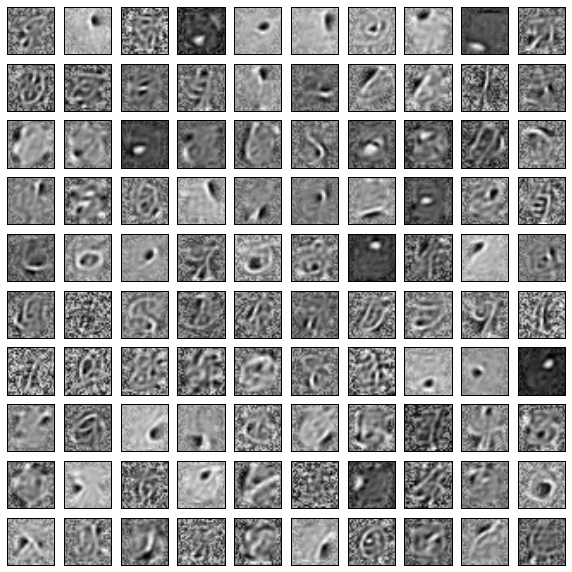

In [16]:
weight = model.W.get_value(borrow=True).T

fig = plt.figure(figsize=(10, 10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(weight[i].reshape((28,28)), cmap='gray')

データの生成

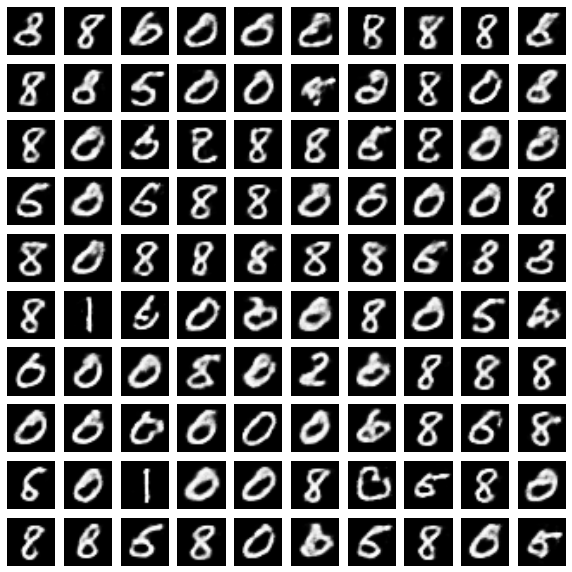

In [17]:
#gibbs sampling
v = T.matrix("v")
[sample_v,mean_v], updates = theano.scan(fn=model.gibbs_vhv, outputs_info=[v,None], n_steps=1000)
sample = theano.function([v], [sample_v[-1], mean_v[-1]], updates=updates, allow_input_downcast=True)

#seed
test_X = shuffle(test_X)
sample_v, mean_v = sample(test_X[0:100])

fig = plt.figure(figsize=(10, 10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(mean_v[i].reshape((28,28)), cmap='gray')

## Stacked auto-encoderの実装

In [ ]:
import numpy as np
import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams
from collections import OrderedDict
rng = np.random.RandomState(1234)

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

from sklearn.metrics import f1_score
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist_x, mnist_y = mnist.data.astype("float32")/255.0, mnist.target.astype("int32")

以下のセルを完成させて提出

In [ ]:
#Autoencoder (or RBM)
class Autoencoder:
    def __init__(self,visible_dim,hidden_dim,W,function):
        ## WRITE ME
        
    #encoder
    def encode(self,x):
        ## WRITE ME
    
    #decoder
    def decode(self,x):
        ## WRITE ME
    
    #forward propagation
    def prop(self,x):
        ## WRITE ME
    
    #reconstruction error
    def reconst_error(self,x,noise):
        ## WRITE ME
        
#SGD
def sgd(params,gparams,lr=0.1):
    updates = OrderedDict()
    for param, gparam in zip(params, gparams):
        updates[param] = param - lr * gparam
    return updates
    
#Multi Layer Perceptron
class Layer:
    def __init__(self, in_dim, out_dim, function):
        ## WRITE ME
        self.set_pretraining()

    def fprop(self, x):
        ## WRITE ME
    
    def set_pretraining(self):
        ae = Autoencoder(self.in_dim,self.out_dim,self.W,self.function)

        x = T.matrix('x')
        noise = T.matrix('noise')

        cost,reconst_x = ae.reconst_error(x,noise)
        params  = ae.params
        gparams = T.grad(cost, params)
        updates = sgd(params,gparams)

        self.pretraining = theano.function([x,noise], [cost,reconst_x], updates=updates, allow_input_downcast=True)
        
        hidden = ae.encode(x)
        self.encode_function = theano.function([x], hidden, allow_input_downcast=True)

train_X, valid_X, train_y, valid_y = train_test_split(mnist_x, mnist_y, test_size=0.2, random_state=42)

layers = [## WRITE ME
]

#Pre-training
X = train_X
for l, layer in enumerate(layers[:-1]):
    corruption_level = ## WRITE ME
    batch_size = 100
    nbatches = X.shape[0] // batch_size

    for epoch in range(10):
        ## WRITE ME
        print "Pre-training:: layer:%d, Epoch:%d, Error:%lf" %(l,epoch, np.mean(err))
    X = layer.encode_function(X)

#Fine-tuning
x, t = T.fmatrix("x"), T.ivector("t")
params = []
for i, layer in enumerate(layers):
    params += layer.params
    if i == 0:
        layer_out = layer.fprop(x)
    else:
        layer_out = layer.fprop(layer_out)

y = layers[-1].h
cost = - T.mean((T.log(y))[T.arange(x.shape[0]), t])

gparams = T.grad(cost, params)
updates = sgd(params,gparams)

train = theano.function([x,t], cost, updates=updates)
valid  = theano.function([x,t],[cost, T.argmax(y, axis=1)])
test  = theano.function([x],T.argmax(y, axis=1))

batch_size = 100
nbatches = train_X.shape[0]//batch_size
for epoch in range(50):
    ## WRITE ME
    print "EPOCH:: %i, Validation cost: %.3f, Validation F1: %.3f"%(epoch+1, valid_cost, f1_score(valid_y, pred, average="macro"))

#pred_y = test(test_X)